In [2]:
import os
import ujson as json
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm

from tqdm import tqdm
from collections import Counter
from collections import defaultdict

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, f1_score

In [8]:
df = pd.read_parquet("./superhost_5percent.parquet")
print("Loaded shape:", df.shape)
print(df.head())

Loaded shape: (29670, 65547)
               ip                                              plist  \
0     5.78.73.148  [22, 23, 66, 80, 81, 88, 443, 465, 500, 587, 9...   
1   51.81.152.174  [22, 4000, 4011, 4013, 4016, 4083, 4084, 4085,...   
2  172.65.239.252  [80, 81, 82, 83, 88, 101, 102, 103, 104, 109, ...   
3    108.62.5.176  [2, 21, 22, 23, 25, 43, 53, 59, 61, 75, 80, 81...   
4     14.0.117.60  [80, 81, 82, 83, 88, 400, 443, 808, 888, 1000,...   

                                          transports  \
0  [TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, UDP, ...   
1  [TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, ...   
2  [TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, ...   
3  [TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, ...   
4  [TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, TCP, ...   

                                       service_names  \
0  [HTTP, HTTP, HTTP, HTTP, HTTP, HTTP, UNKNOWN, ...   
1  [SSH, UNKNOWN, UNKNOWN, UNKNOWN, UNKNOWN, UNKN...   
2  [UNKNOWN, UNKNOWN, UNKNOWN, UN

In [9]:
# Declare Bucket Size
bucket_size = 100

# Measures the entropy of port spaces 
def port_entropy(row):
    ports = np.flatnonzero(row) + 1
    if len(ports) == 0:
        return 0
    counts = np.bincount(ports % 1000, minlength=1000)
    probs = counts / counts.sum()
    return entropy(probs, base=2)

MAX_PORT = 65535
num_buckets = ((MAX_PORT - 1) // bucket_size) + 1

port_cols = [col for col in df.columns if col.startswith("port")]

# Create a DataFrame with bucketed labels
bucket_matrix = np.zeros((len(df), num_buckets), dtype=np.uint8)

for i, row in enumerate(df[port_cols].values):
    collective_ports = np.flatnonzero(row) + 1
    for port in collective_ports:
        bucket_idx = port // bucket_size
        bucket_matrix[i, bucket_idx] = 1

col_names = [f"bucket_{i * bucket_size + 1}-{min((i + 1) * bucket_size, MAX_PORT)}" for i in range(num_buckets)]

y = pd.DataFrame(bucket_matrix, columns=col_names)
X = pd.DataFrame(index=df.index)
# Organization
X["org_name"] = df["org_name"].astype("category").cat.codes
# Autonomous system info
X["asn"] = pd.to_numeric(df["asn"], errors="coerce").astype("Int64")
# Country code
X["country_code"] = df["country_code"].astype("category").cat.codes
# Province or region
X["province"] = df["province"].astype("category").cat.codes
# Reverse DNS presence
X["has_reverse_dns"] = df["has_reverse_dns"].astype(int)
# Transport ratios
X["udp_ratio"] = df["transports"].apply(lambda lst: np.sum(np.array(lst) == "UDP") / len(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else 0)
# Service diversity
X["unique_services"] = df["service_names"].apply(lambda lst: len(set(lst)) if isinstance(lst, list) else 0)
# Top service indicator (e.g., SVR count)
X["num_svr"] = df["service_names"].apply(lambda lst: lst.count("SVR") if isinstance(lst, list) else 0)
# Port statistics
X["num_ports_active"] = df[port_cols].sum(axis=1)
# Port Entropy analysis using Shannon Entropy
X["port_entropy"] = df[port_cols].apply(port_entropy, axis=1)
# Bucket co-occurrences
bucket_matrix = y.values
num_buckets = bucket_matrix.shape[1]
co_matrix = (bucket_matrix.T @ bucket_matrix).astype(np.int32)
co_bucket_map = {}
for i in range(num_buckets):
    co_matrix[i, i] = -1
    top5 = np.argsort(co_matrix[i])[::-1][:5]
    co_bucket_map[i] = top5

co_bucket_features = np.zeros((len(bucket_matrix), num_buckets), dtype=np.uint8)

for i in range(num_buckets):
    related = co_bucket_map[i]
    co_bucket_features[:, i] = (
        (bucket_matrix[:, i] == 1) * bucket_matrix[:, related].sum(axis=1)
    ).astype(np.uint8)

co_bucket_features = co_bucket_features / 5.0

bucket_col_names = y.columns.tolist()
co_bucket_col_names = [f"{name}_coactive_top5" for name in bucket_col_names]
co_bucket_df = pd.DataFrame(co_bucket_features, columns=co_bucket_col_names, index=df.index)

X = pd.concat([X, co_bucket_df], axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test     = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from joblib import Parallel, delayed

# Define training function for a single bucket
def train_bucket_model(bucket_name, X_train, y_train, X_val, y_val):
    print(f"\n=== Training bucket (size = {bucket_size}) classifier for {bucket_name}", flush=True)
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=6,
        task_type="CPU",
        loss_function="Logloss",
        eval_metric="Logloss",
        use_best_model=True,
        early_stopping_rounds=30,
        verbose=0
    )
    model.fit(X_train, y_train[bucket_name], eval_set=(X_val, y_val[bucket_name]))
    return bucket_name, model

print(f"\n Starting parallel training for {len(y_train.columns)} buckets...")

n_jobs = -1  # use all available CPU threads 
results = Parallel(n_jobs=n_jobs, backend="threading")(
    delayed(train_bucket_model)(bucket, X_train, y_train, X_val, y_val)
    for bucket in y_train.columns
)

# Store trained models 
port_buckets = {bucket: model for bucket, model in results}

# Predict
y_val_pred = pd.DataFrame({
    bucket: model.predict(X_val).ravel()
    for bucket, model in port_buckets.items()
}, index=X_val.index)

# Evaluation
print("\n Evaluation of parallel-trained bucket classifiers:")
print("Macro-F1:", f1_score(y_val, y_val_pred, average="macro", zero_division=0))
print("Micro-F1:", f1_score(y_val, y_val_pred, average="micro", zero_division=0))
print("Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))


 Starting parallel training for 656 buckets...

=== Training bucket (size = 100) classifier for bucket_1-100

=== Training bucket (size = 100) classifier for bucket_101-200

=== Training bucket (size = 100) classifier for bucket_201-300

=== Training bucket (size = 100) classifier for bucket_301-400

=== Training bucket (size = 100) classifier for bucket_401-500



=== Training bucket (size = 100) classifier for bucket_501-600

=== Training bucket (size = 100) classifier for bucket_601-700

=== Training bucket (size = 100) classifier for bucket_701-800

=== Training bucket (size = 100) classifier for bucket_801-900

=== Training bucket (size = 100) classifier for bucket_901-1000

=== Training bucket (size = 100) classifier for bucket_1001-1100

=== Training bucket (size = 100) classifier for bucket_1101-1200

=== Training bucket (size = 100) classifier for bucket_1201-1300
=== Training bucket (size = 100) classifier for bucket_1301-1400


=== Training bucket (size = 100) classifier for bucket_1401-1500

=== Training bucket (size = 100) classifier for bucket_1501-1600

=== Training bucket (size = 100) classifier for bucket_1601-1700

=== Training bucket (size = 100) classifier for bucket_1701-1800

=== Training bucket (size = 100) classifier for bucket_1801-1900

=== Training bucket (size = 100) classifier for bucket_1901-2000

=== Training bucke

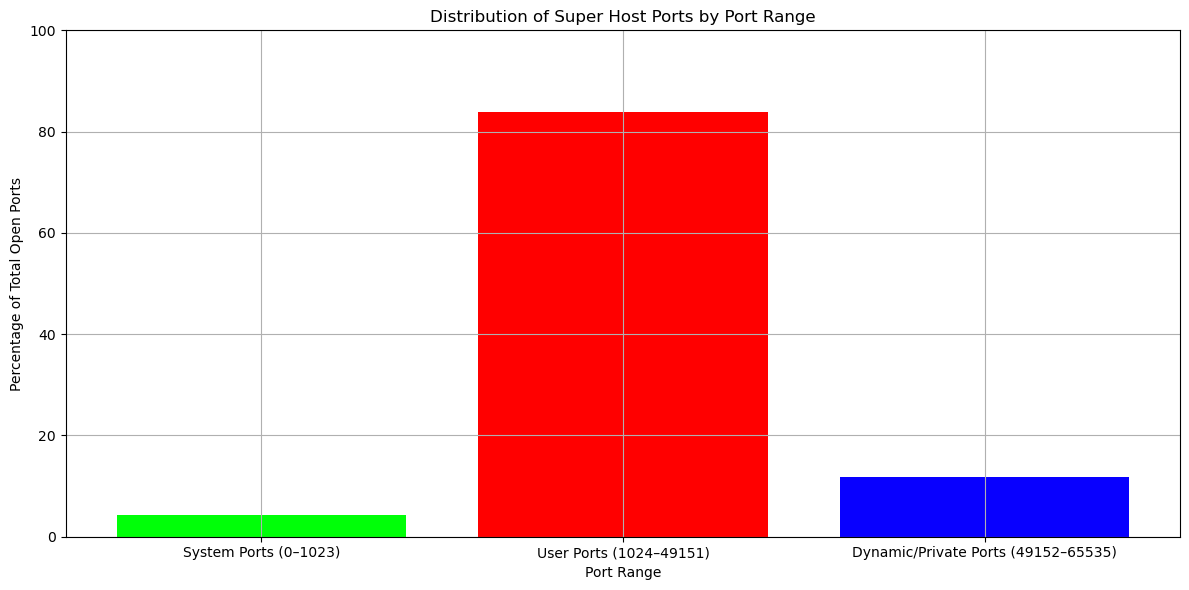

=== Port Usage Statistics ===
Total unique IPv4 hosts: 29900
Average number of ports per host: 348.27
Standard deviation of ports per host: 425.28
Minimum number of ports on a host: 1
Maximum number of ports on a host: 9760


In [ ]:
# Extract port numbers from column names
port_cols = [col for col in df.columns if col.startswith("port")]
port_nums = [int(col.split("_")[1]) for col in port_cols]

# Map each column to its port range category
range_labels = []
for p in port_nums:
    if p <= 1023:
        range_labels.append("System Ports (0–1023)")
    elif p <= 49151:
        range_labels.append("User Ports (1024–49151)")
    else:
        range_labels.append("Dynamic/Private Ports (49152–65535)")

# Sum total active ports for each column
port_totals = df[port_cols].sum(axis=0)

# Combine port counts into their range buckets
from collections import defaultdict
range_counts = defaultdict(int)
for label, count in zip(range_labels, port_totals):
    range_counts[label] += count

# Normalize to percentage
total_ports_open = sum(range_counts.values())
range_percentages = {k: v * 100 / total_ports_open for k, v in range_counts.items()}

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range_percentages.keys(), range_percentages.values(), color=["#00FF08", "#ff0000", "#0800ff"])
plt.title("Distribution of Super Host Ports by Port Range")
plt.xlabel("Port Range")
plt.ylabel("Percentage of Total Open Ports")
plt.ylim(0, 100)
plt.tight_layout()
plt.grid(True)
plt.show()

# Host-level statistics
host_port_counts = df[port_cols].sum(axis=1)  # sum across columns for each row (host)

# Print summary statistics
print("=== Port Usage Statistics ===")
print(f"Total unique IPv4 hosts: {len(df)}")
print(f"Average number of ports per host: {host_port_counts.mean():.2f}")
print(f"Standard deviation of ports per host: {host_port_counts.std():.2f}")
print(f"Minimum number of ports on a host: {host_port_counts.min()}")
print(f"Maximum number of ports on a host: {host_port_counts.max()}")

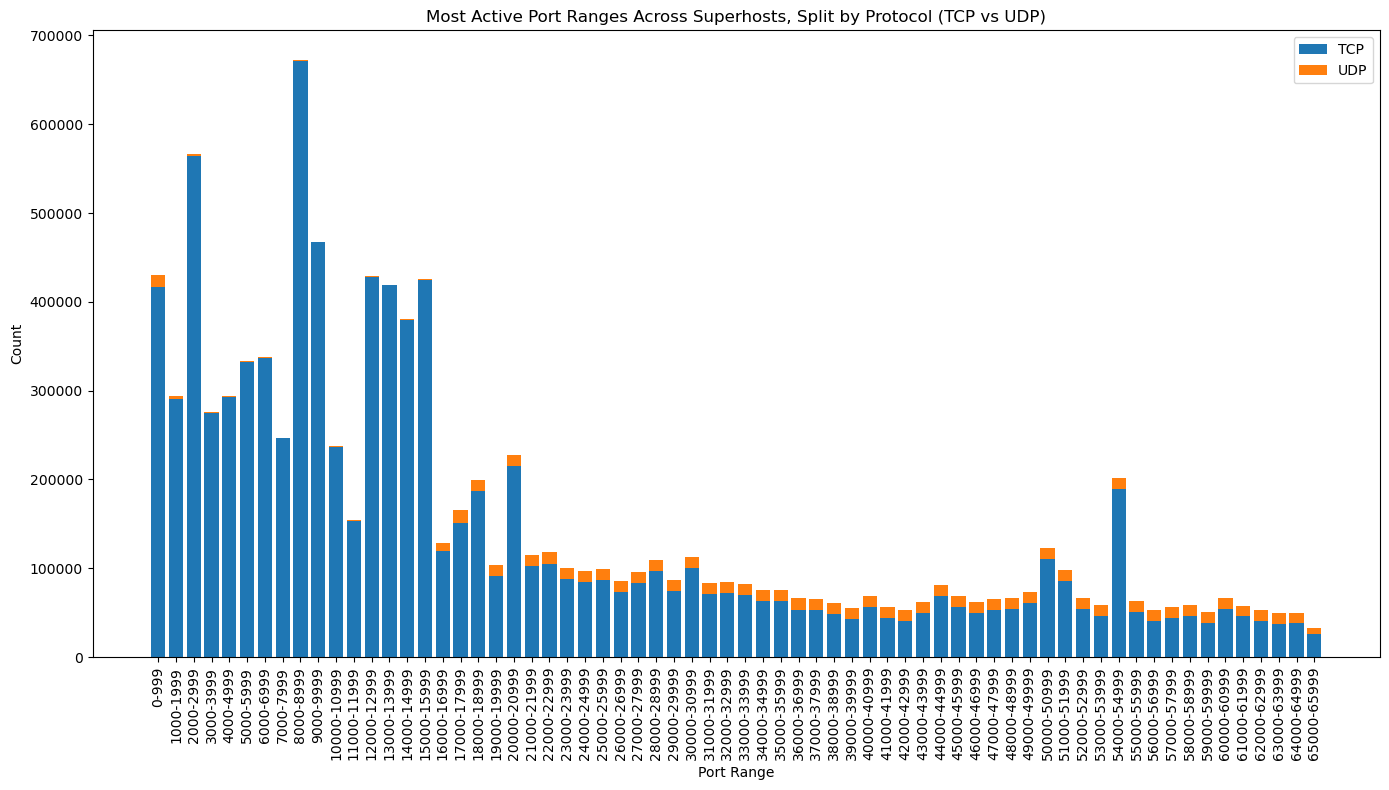

In [29]:
fig_bucket_size = 1000
port_protocol_pairs = [(p, t) for ports, transports in zip(df["plist"], df["transports"]) for p, t in zip(ports, transports)]
buckets = list(range(0, MAX_PORT + fig_bucket_size, fig_bucket_size))
bucket_labels = [f"{b}-{b + fig_bucket_size - 1}" for b in buckets[:-1]]
bucket_counts = defaultdict(lambda: {"TCP": 0, "UDP": 0})

for port, proto in port_protocol_pairs:
    bucket_index = port // fig_bucket_size
    if bucket_index < len(bucket_labels):
        label = bucket_labels[bucket_index]
        if proto in ("TCP", "UDP"):
            bucket_counts[label][proto] += 1

# Step 4: Build DataFrame
bucket_df = pd.DataFrame.from_dict(bucket_counts, orient='index').reindex(bucket_labels, fill_value=0)

# Step 5: Plot stacked bar chart
plt.figure(figsize=(14, 8))
plt.bar(bucket_df.index, bucket_df["TCP"], label="TCP")
plt.bar(bucket_df.index, bucket_df["UDP"], bottom=bucket_df["TCP"], label="UDP")
plt.xticks(rotation=90)
plt.xlabel("Port Range")
plt.ylabel("Count")
plt.title("Most Active Port Ranges Across Superhosts, Split by Protocol (TCP vs UDP)")
plt.legend()
plt.tight_layout()
plt.show()


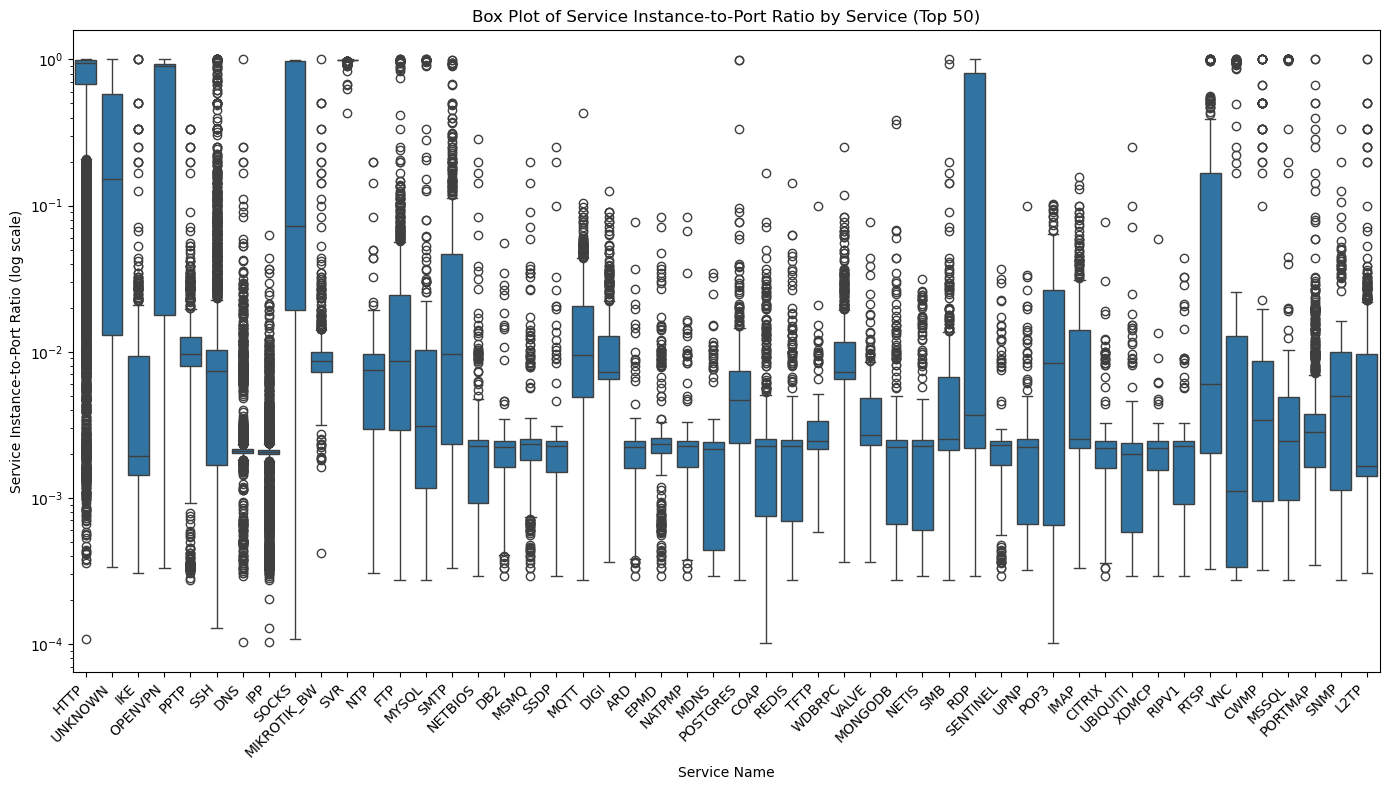

In [24]:
num_of_types = 50

records = []

for services, ports in zip(df["service_names"], df["plist"]):
    n_ports = len(ports)
    if n_ports == 0:
        continue  # avoid division by zero
    
    service_counts = Counter(services)  # count how many ports each service appears on this host
    
    for service, count in service_counts.items():
        ratio = count / n_ports
        records.append((service, ratio))

# Step 2: Create DataFrame
df_plot = pd.DataFrame(records, columns=["service", "ratio"])

# Step 3: Filter to top N most common service types
top_services = df_plot["service"].value_counts().head(num_of_types).index
df_top = df_plot[df_plot["service"].isin(top_services)]

# Step 4: Plot boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top, x="service", y="ratio")
plt.xticks(rotation=45, ha='right')
plt.yscale("log")
plt.xlabel("Service Name")
plt.ylabel("Service Instance-to-Port Ratio (log scale)")
plt.title(f"Box Plot of Service Instance-to-Port Ratio by Service (Top {num_of_types})")
plt.tight_layout()
plt.show()

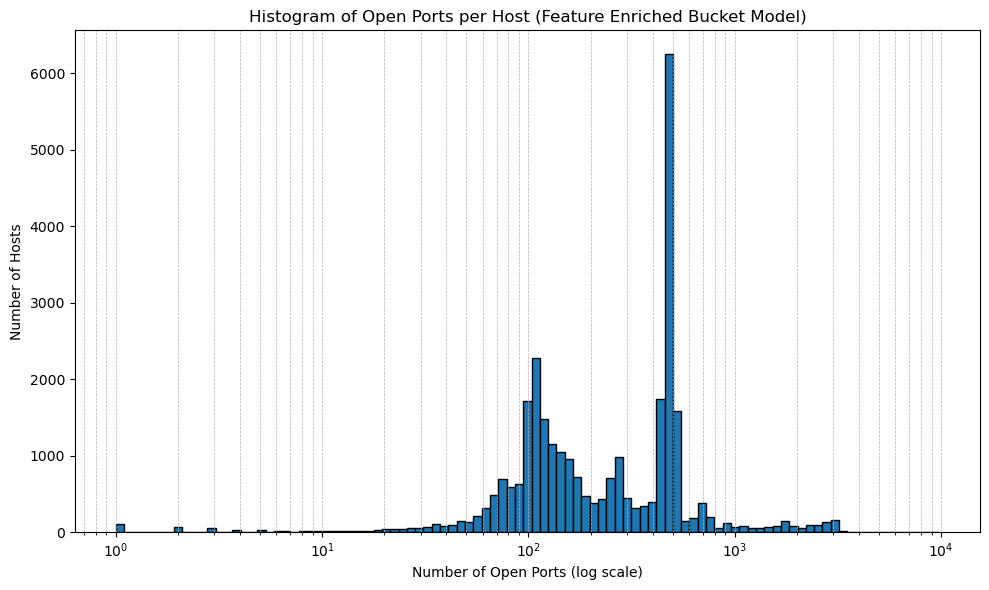

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(host_port_counts, bins=np.logspace(0, np.log10(host_port_counts.max()+1), 100), edgecolor='black')
plt.xscale('log')
plt.title("Histogram of Open Ports per Host (Feature Enriched Bucket Model)")
plt.xlabel("Number of Open Ports (log scale)")
plt.ylabel("Number of Hosts")
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

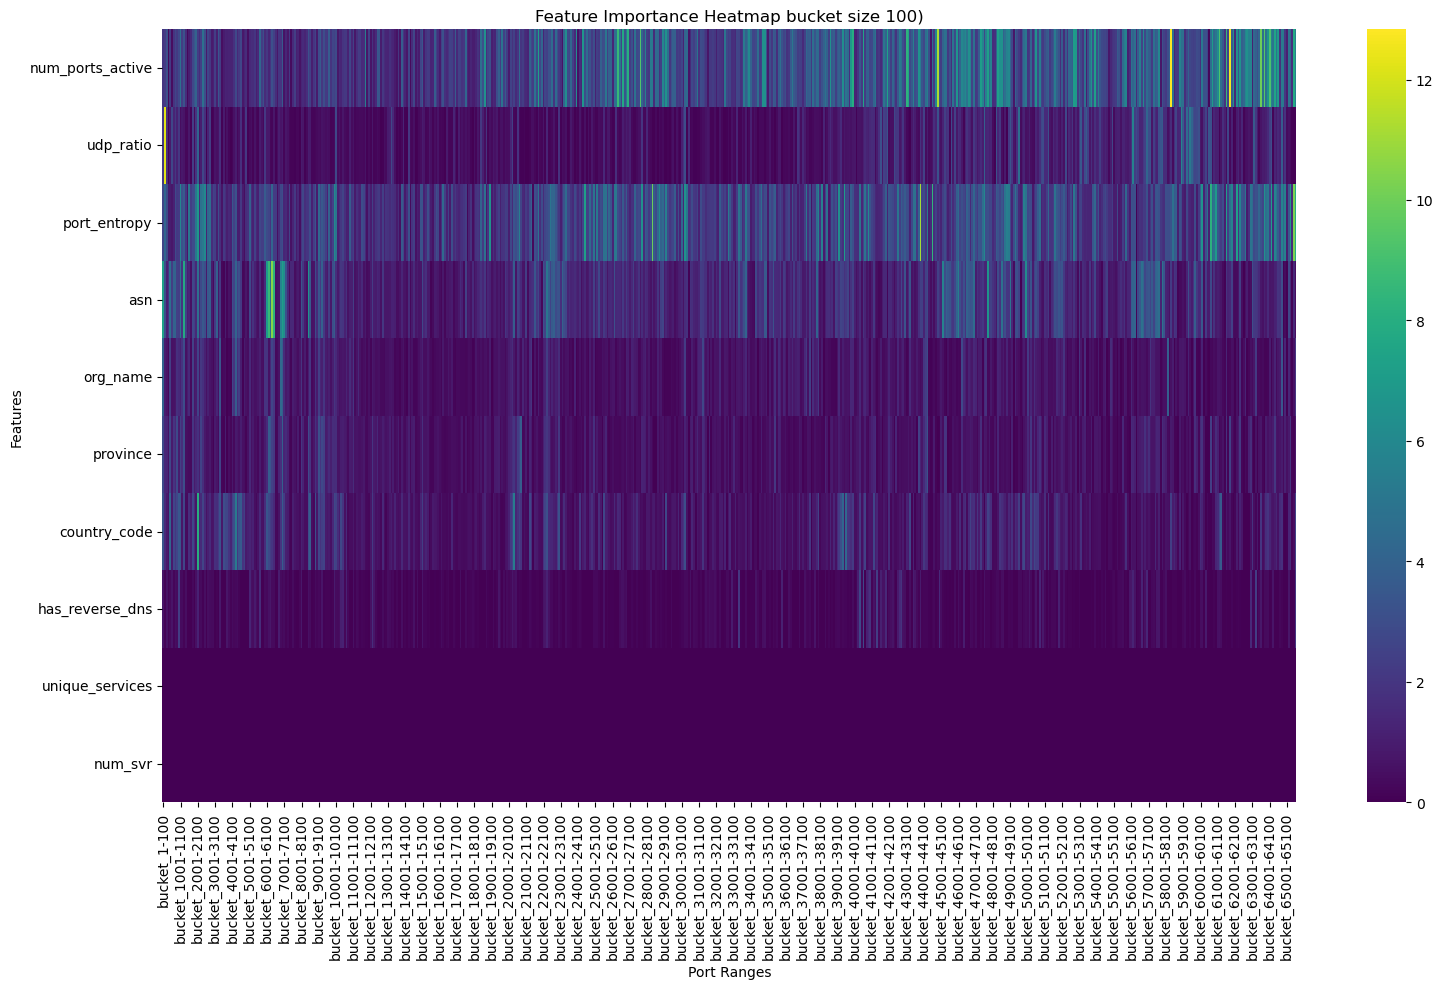

In [7]:
# List of structured features
structured_features = [
    'num_ports_active', 'udp_ratio', 'port_entropy', 'asn', 'org_name',
    'province', 'country_code', 'has_reverse_dns', 'unique_services', 'num_svr'
]

# Get feature indices of structured features
feature_names = X_train.columns.tolist()
structured_indices = [feature_names.index(f) for f in structured_features]

# Gather importances
importance_matrix = []

for bucket in port_buckets.keys():
    model = port_buckets[bucket]
    
    # Raw importances (aligned with X_train.columns)
    importances = model.get_feature_importance()
    
    # Select only structured feature importances
    structured_importances = importances[structured_indices]
    
    importance_matrix.append(structured_importances)

# Build DataFrame for heatmap
importance_df = pd.DataFrame(
    importance_matrix,
    columns=structured_features,
    index=port_buckets.keys()
).T  # Transpose to have features on Y-axis

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(importance_df, cmap="viridis")
plt.title(f"Feature Importance Heatmap bucket size {bucket_size})")
plt.xlabel("Port Ranges")
plt.ylabel("Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

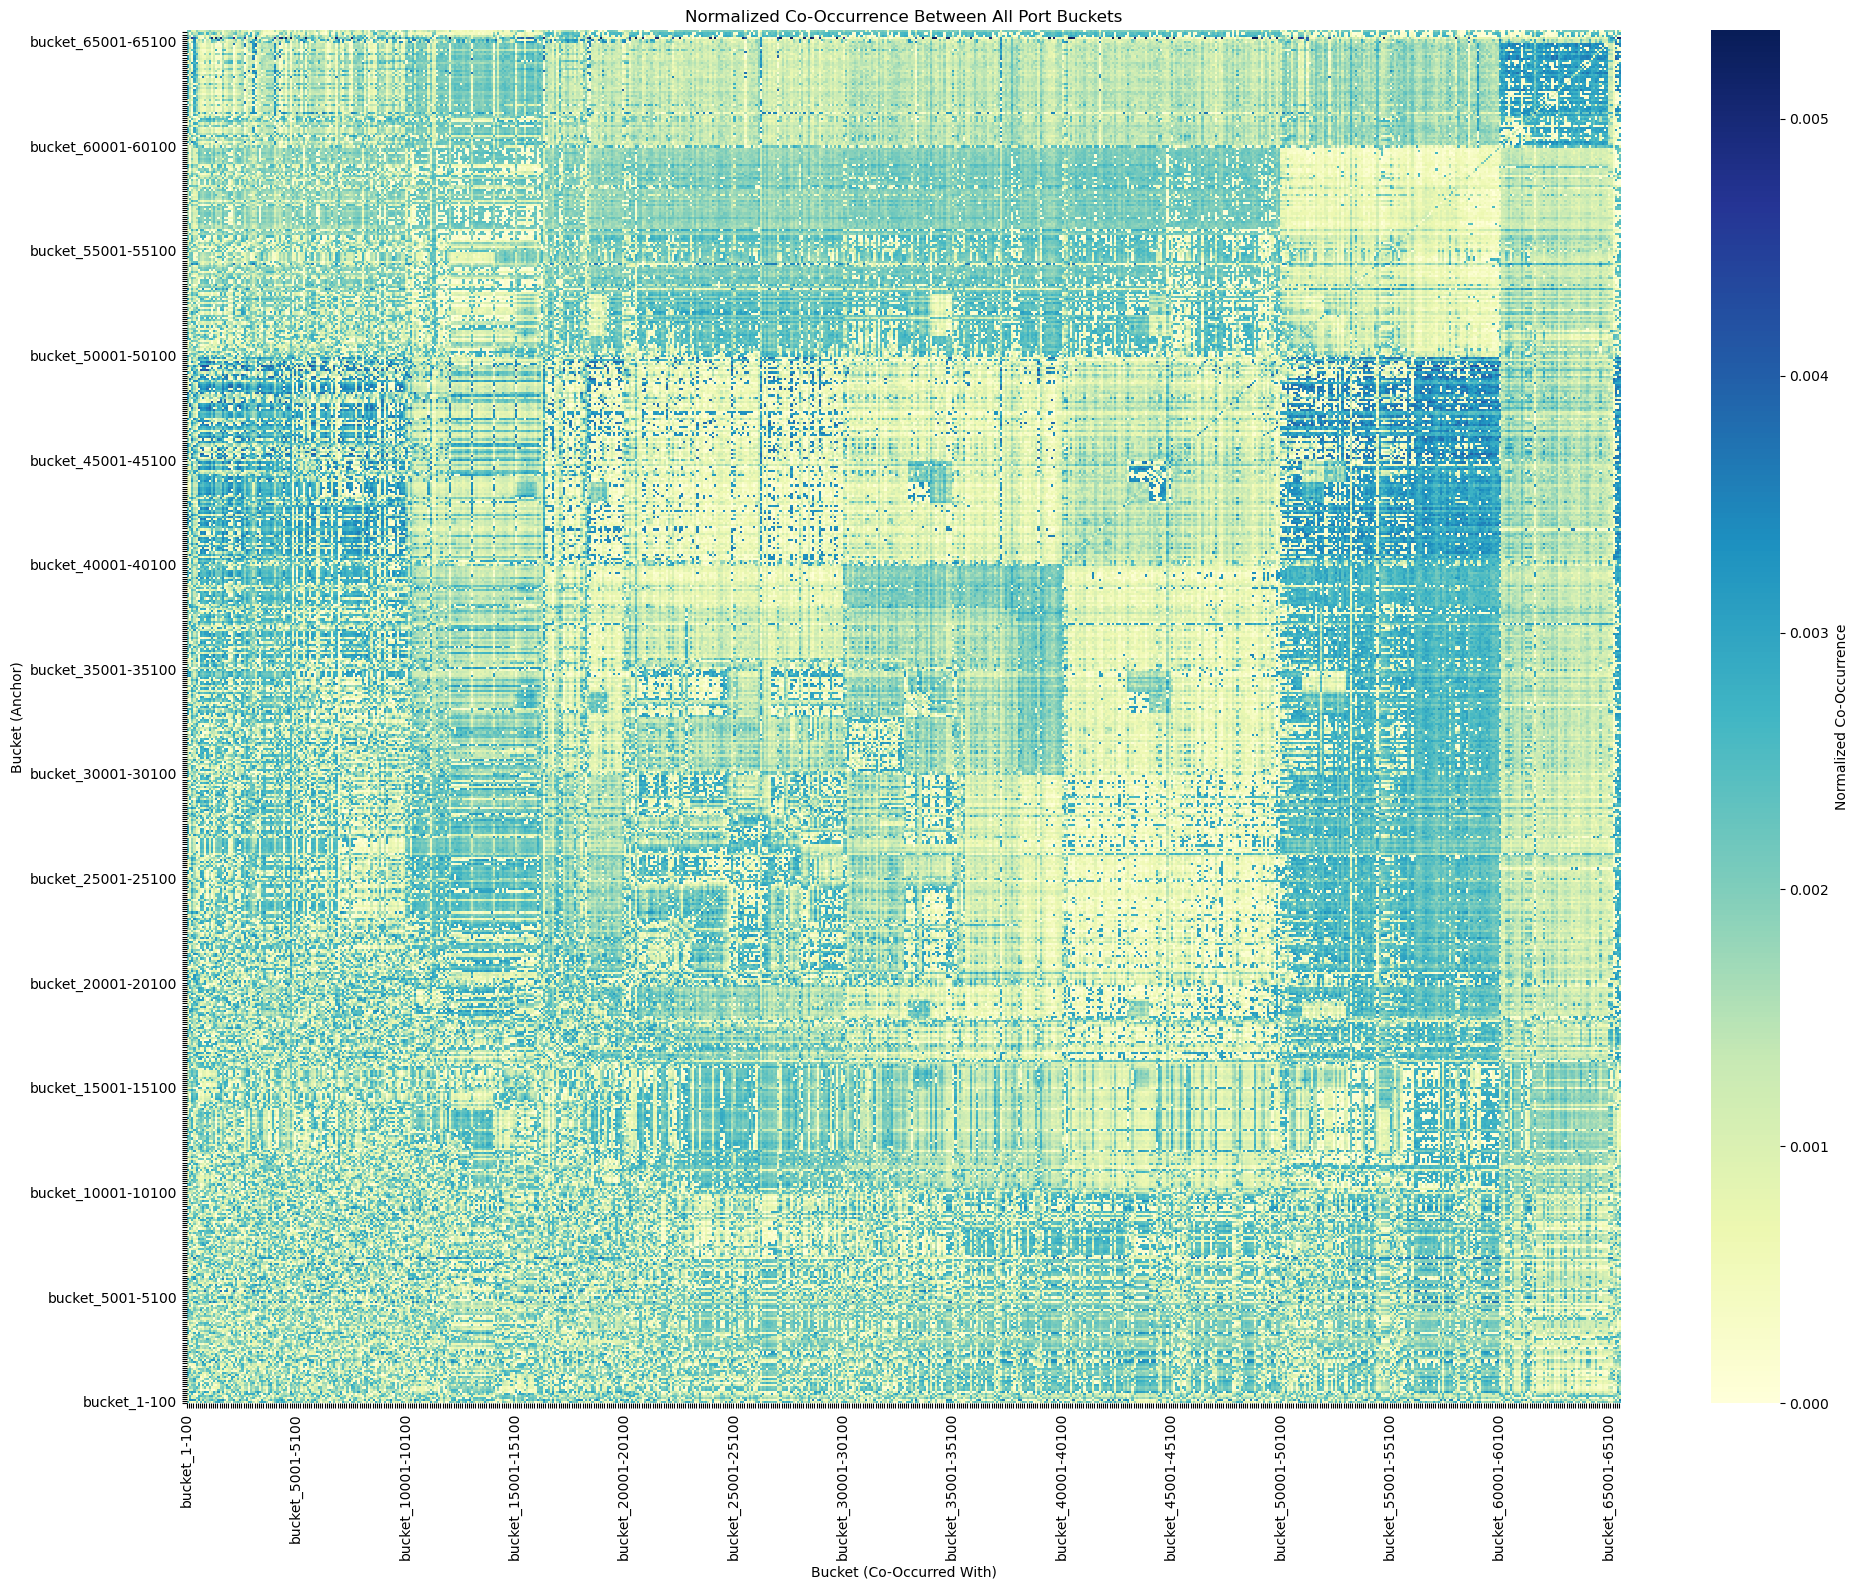

In [ ]:
bucket_matrix = y.values 
col_names = y.columns.tolist()
num_buckets = bucket_matrix.shape[1]

# Full co-occurrence matrix
co_matrix = (bucket_matrix.T @ bucket_matrix).astype(np.int32)

# Normalize each row to sum to 1
row_sums = co_matrix.sum(axis=1, keepdims=True)
normalized_matrix = np.divide(
    co_matrix, row_sums, out=np.zeros_like(co_matrix, dtype=float), where=row_sums != 0
)

# Plot
fig, ax = plt.subplots(figsize=(20, 16))

# Plot normally, but flip y-axis after
sns.heatmap(
    normalized_matrix,            
    xticklabels=col_names,
    yticklabels=col_names,
    cmap="YlGnBu",
    annot=False,
    cbar_kws={'label': 'Normalized Co-Occurrence'}
)

# Invert Y-axis so lowest bucket is at bottom
ax.invert_yaxis()

# Format tick labels
N = 50
ax.set_xticks(np.arange(len(col_names)))
ax.set_xticklabels(col_names, rotation=90)
ax.set_yticks(np.arange(len(col_names)))
ax.set_yticklabels(col_names)

# Reduce clutter: hide every Nth label
for i, label in enumerate(ax.get_xticklabels()):
    if i % N != 0:
        label.set_visible(False)
for i, label in enumerate(ax.get_yticklabels()):
    if i % N != 0:
        label.set_visible(False)

plt.title("Normalized Co-Occurrence Between All Port Buckets")
plt.xlabel("Bucket (Co-Occurred With)")
plt.ylabel("Bucket (Anchor)")
plt.tight_layout()
plt.show()

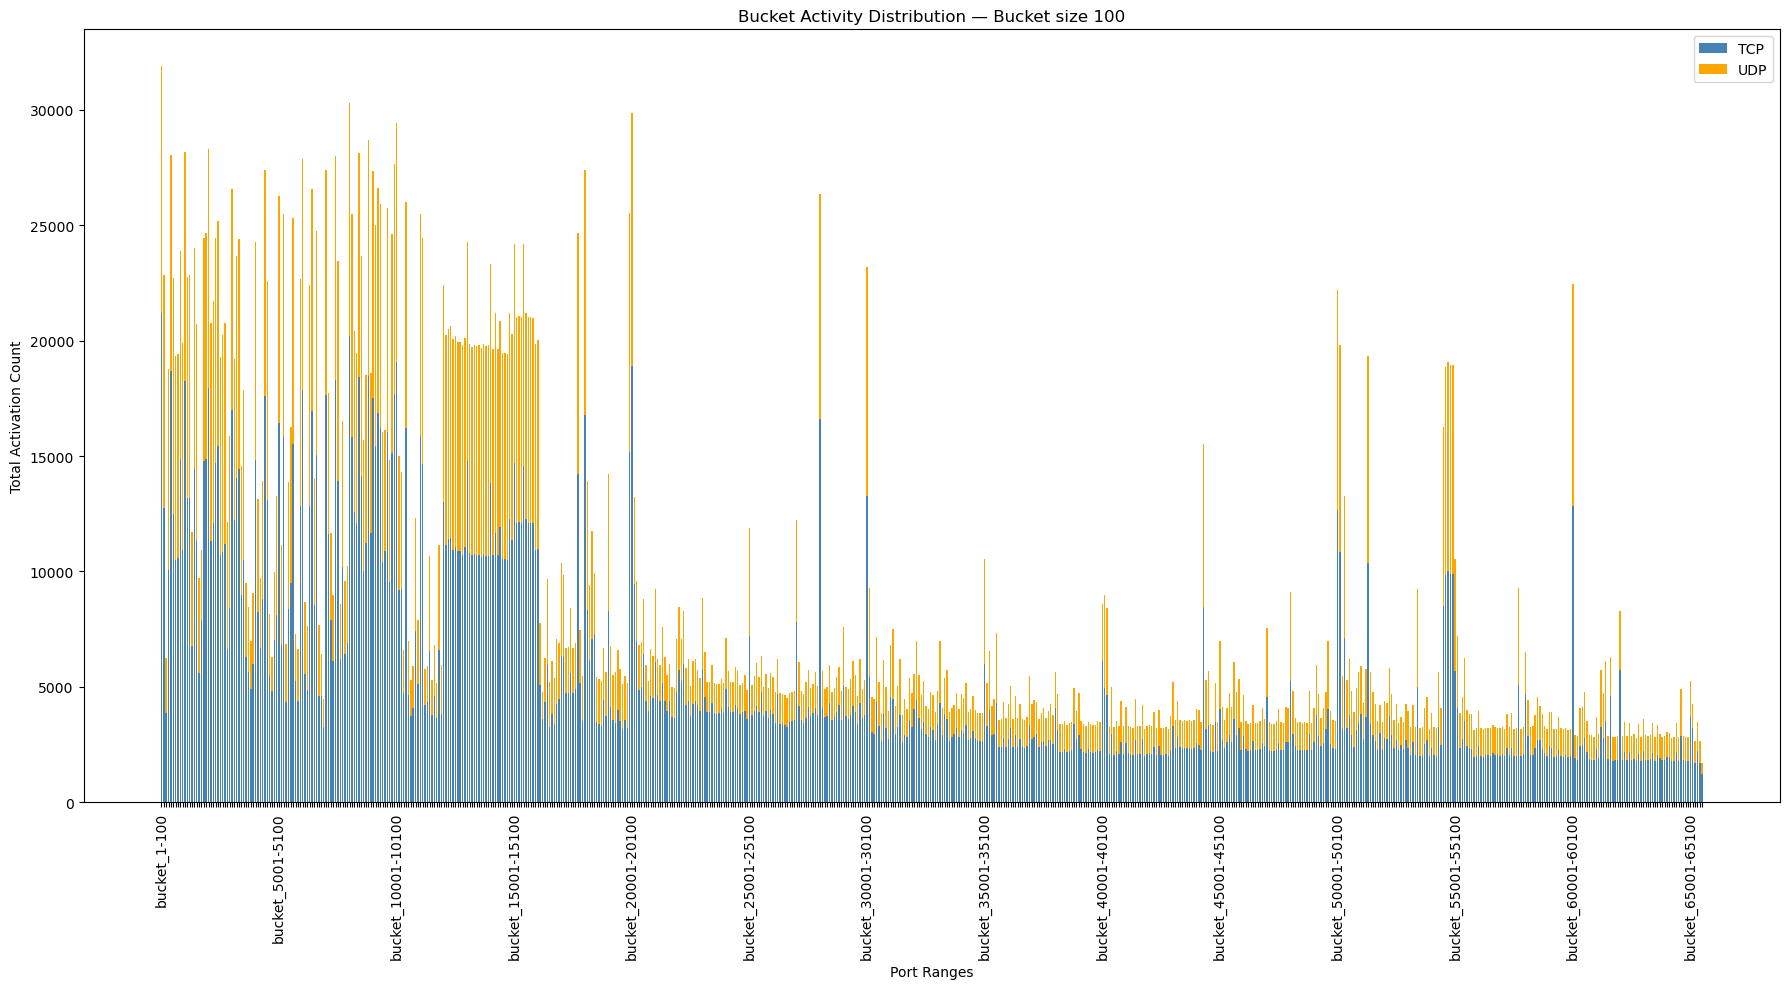

In [ ]:
tcp_hosts = df[df["transports"].apply(lambda x: "TCP" in set(x))].index
udp_hosts = df[df["transports"].apply(lambda x: "UDP" in set(x))].index

tcp_support = y.loc[tcp_hosts].sum(axis=0)
udp_support = y.loc[udp_hosts].sum(axis=0)

sort_key = lambda idx: [int(b.split("_")[1].split("-")[0]) for b in idx]
tcp_support_sorted = tcp_support.sort_index(key=sort_key)
udp_support_sorted = udp_support.sort_index(key=sort_key)

fig, ax = plt.subplots(figsize=(18, 10))

x = range(len(tcp_support_sorted))

# Plot TCP first
ax.bar(
    x,
    tcp_support_sorted,
    width=0.6,
    label="TCP",
    color="steelblue"
)

# Plot UDP stacked on top
ax.bar(
    x,
    udp_support_sorted,
    width=0.6,
    bottom=tcp_support_sorted,
    label="UDP",
    color="orange"
)

# Set x-tick labels
xtick_labels = tcp_support_sorted.index
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=90)
for i, label in enumerate(ax.get_xticklabels()):
    if i % 50 != 0:
        label.set_visible(False)

plt.title(f"Bucket Activity Distribution — Bucket size {bucket_size}")
plt.xlabel("Port Ranges")
plt.ylabel("Total Activation Count")
plt.legend()
plt.tight_layout()
plt.show()